# Spectrum Anomaly Detection for Optical Network Monitoring using Deep Unsupervised Learning

**Authors:** [Carlos Natalino](https://www.chalmers.se/en/staff/Pages/Carlos-Natalino-Da-Silva.aspx)\*, Aleksejs Udalcovs\*\*, Lena Wosinska\*, Oskars Ozolins\*\*, [Marija Furdek](https://www.chalmers.se/en/staff/Pages/Marija-Furdek-Prekratic.aspx)\*

\* Department of Electrical Engineering, Chalmers University of Technology, Gothenburg, Sweden (e-mail: carlos.natalino@chalmers.se, wosinska@chalmers.se, furdek@chalmers.se).

\*\* RISE Research Institutes of Sweden, Kista, Sweden (e-mail: aleksejs.udalcovs@ri.se, oskars.ozolins@ri.se).

## Evaluating the performance of the models in terms of runtime

In [1]:
import os
import numpy as np
import imageio
import pickle
import time

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.cluster import DBSCAN

from tensorflow.keras.models import Model, load_model

from IPython.core.display import display, HTML
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

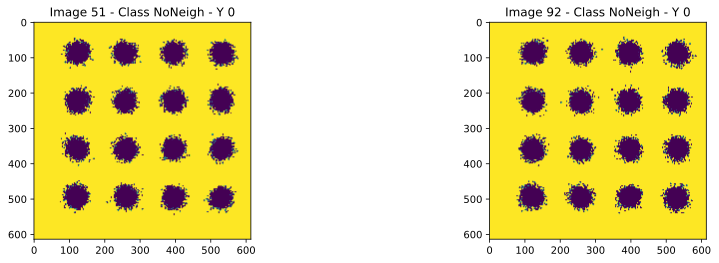

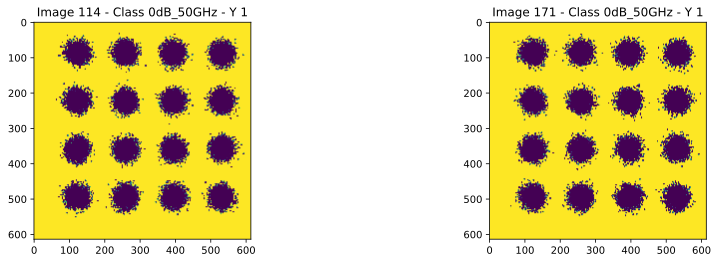

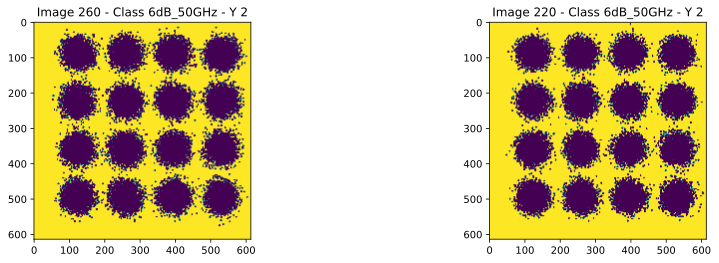

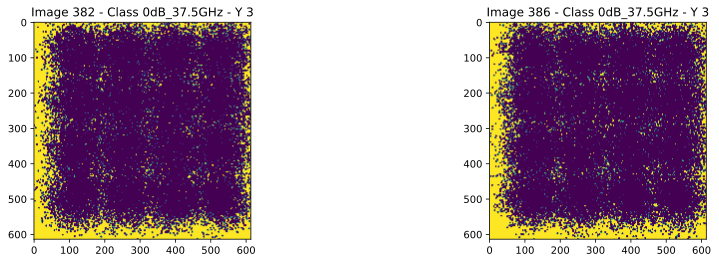

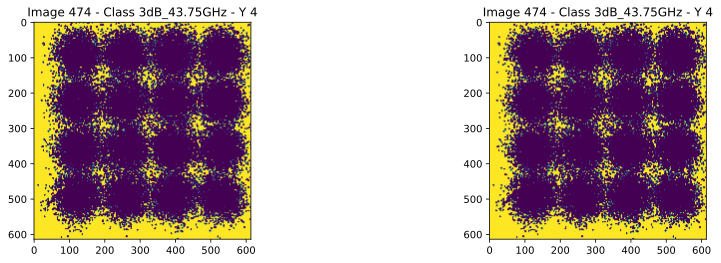

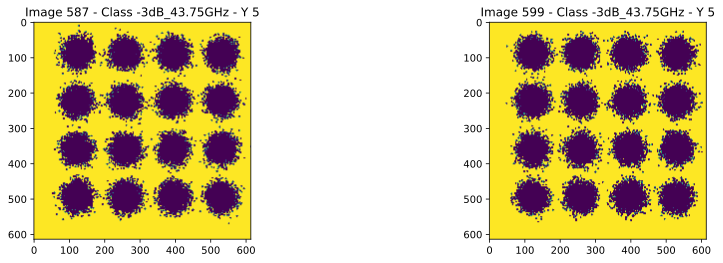

In [2]:
np.random.seed(42)

normal_classes = [0, 1]
anomalous_classes = [2, 3, 4, 5]
classes = ['NoNeigh',
           '0dB_50GHz',
           '6dB_50GHz',
           '0dB_37.5GHz',
           '3dB_43.75GHz',
           '-3dB_43.75GHz']
folders = ['/NoJamming/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_0dB_Gap_50GHz/images',
           '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_6dB_Gap_50GHz/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_0dB_Gap_37.5GHz/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_3dB_Gap_43.75GHz/images',
          '/Results_Sq16QAM_OSNR_40dB_ChSp_50GHz_TxPower_1dBm_16QAM_PwrDiff_-3dB_Gap_43.75GHz/images']

base_folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc'

num_images = len(os.listdir(base_folder + folders[0]))

X = np.zeros((num_images * len(classes), 614, 614, 3))
X_grayscale = np.zeros((num_images * len(classes), 614, 614))
Y = np.zeros((num_images * len(classes)), dtype=int)

for id_class, folder in enumerate(folders):
    folder_path = base_folder + folder

    for i, file in enumerate(os.listdir(folder_path)):
        img = imageio.imread(folder_path + '/' + file)
        new_image = img[131:745, 277:891, :]
        X[id_class*num_images+i, :, :, :] = new_image
        X_grayscale[id_class*num_images+i, :, :] = new_image[..., :,1]
    Y[id_class*num_images:(id_class+1)*num_images] = id_class
    
    # plotting some samples
    num_samples = 2
    samples = np.random.choice(num_images, size=num_samples)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 4))
    for i, sample in enumerate(samples):
        axs[i].imshow(X_grayscale[id_class*num_images+sample, :, :])
        axs[i].set_title('Image {} - Class {} - Y {}'.format(id_class*num_images+sample, classes[id_class], Y[id_class*num_images+sample]))
    plt.show()

In [3]:
loaded= load_model('./models/autoencoder.h5')
layer = len(loaded.layers) // 2
encoder = Model(loaded.input, loaded.layers[layer].output)

loaded.summary()
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 614, 614, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 614, 614, 1)       37        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 307, 307, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 307, 307, 16)      592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 154, 154, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 154, 154, 1)       577       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 1)         0     

## Reading the dateset

In [7]:
normal_samples = X_grayscale[np.argwhere(Y <= 1)] # Y == 0 is no neighboring, and Y == 1 is channel neighboring with 0 dB and 50 GHz

x_train, x_test, y_train, y_test = train_test_split(normal_samples, Y[Y <= 1], stratify=Y[Y <= 1], test_size=0.5, random_state=42)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), 614, 614, 1)) # shapes the inputs for what the encoder is expecting
x_test = x_test.reshape((len(x_test), 614, 614, 1))

x_train_encoded = encoder.predict(x_train)
shape_encoded = np.shape(x_train_encoded)
x_train_encoded = x_train_encoded.reshape(shape_encoded[0], shape_encoded[1] * shape_encoded[2]) # we need to reshape to have it in two dimensions

print('done')

done


### Computing averages and standard deviations of each class

In [9]:
averages_full = []
stdevs_full = []
averages_encoded = []
stdevs_encoded = []
for id_clazz, clazz in enumerate(classes):
    x = X_grayscale[np.argwhere(Y == id_clazz)]
    shape = x.shape
    m = np.mean(x.reshape((shape[0], shape[2] * shape[3])), axis=0)#
    averages_full.append(m)
    s = np.std(x.reshape((shape[0], shape[2] * shape[3])), axis=0)#
    stdevs_full.append(s)
    
    x_encoded = encoder.predict(x.reshape(x.shape[0], 614, 614, 1))
    shape = x_encoded.shape
    m = np.mean(x_encoded.reshape((shape[0], shape[1] * shape[2])), axis=0)#
    averages_encoded.append(m)
    s = np.std(x_encoded.reshape((shape[0], shape[1] * shape[2])), axis=0)#
    stdevs_encoded.append(s)

In [10]:
del normal_samples, x_train, x_test, y_train, y_test, x_train_encoded, X # free up memory

## Testing the runtime of the best configuration

Here, we use the best configuration of each approach, and test over a synthetic dataset that is composed using the same properties as the original dataset.

In [4]:
with open('results/performance-metrics.h5', 'rb') as f:
    data = pickle.load(f)
    performance_dbscan_full = data['performance_dbscan_full']
    performance_dbscan_encoded = data['performance_dbscan_encoded']
    performance_ocsvm_encoded = data['performance_ocsvm_encoded']
    performance_ocsvm_full = data['performance_ocsvm_full']

In [8]:
# instantiating the best OCSVM configurations and establishing the normal operating conditions (training)
ocsvm_full = svm.OneClassSVM(nu=0.01, kernel='linear', gamma=0.1)
ocsvm_full.fit(x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2])))
ocsvm_encoded = svm.OneClassSVM(nu=0.01, kernel='rbf', gamma=0.1)
ocsvm_encoded.fit(x_train_encoded)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='rbf',
            max_iter=-1, nu=0.01, shrinking=True, tol=0.001, verbose=False)

In [12]:
results_testing = {}
samples_to_test = [100, 500, 1000, 2500, 5000, 7500, 10000]
algorithms = ['ocsvm_full', 'ocsvm_encoded', 'dbscan_full', 'dbscan_encoded']

for algorithm in algorithms:
    results_testing[algorithm] = {}
    for samples in samples_to_test:
        results_testing[algorithm][samples] = -1.

for number_samples in samples_to_test:
    print(number_samples)
    dataset = None
    for i in normal_classes:
        samples = np.random.normal(averages_encoded[i], stdevs_encoded[i], (number_samples, encoder.layers[-1].output.shape[1]*encoder.layers[-1].output.shape[2]))
        if dataset is None:
            dataset = samples
        else:
            dataset = np.concatenate((dataset, samples))
    
    n = int(number_samples * 15 / 100)
    for i in anomalous_classes:
        samples = np.random.normal(averages_encoded[i], stdevs_encoded[i], (n, encoder.layers[-1].output.shape[1]*encoder.layers[-1].output.shape[2]))
        if dataset is None:
            dataset = samples
        else:
            dataset = np.concatenate((dataset, samples))
    
    # dataset is ready for testing
    start_time = time.time()
    result = ocsvm_encoded.predict(dataset)
    end_time = time.time()
    results_testing['ocsvm_encoded'][number_samples] = end_time - start_time
    print('\t ocsvm encoded', end_time - start_time)
    
    dbscan = DBSCAN(eps=1., min_samples=10, metric='euclidean')
    start_time = time.time()
    result = dbscan.fit_predict(dataset)
    end_time = time.time()
    results_testing['dbscan_encoded'][number_samples] = end_time - start_time
    print('\t dbscan encoded', end_time - start_time)
    del dataset, samples
        
for number_samples in samples_to_test:
    try:
        print(number_samples)
        dataset = None
        for i in normal_classes:
            samples = np.random.normal(averages_full[i], stdevs_full[i], (number_samples, encoder.layers[0].input.shape[1]*encoder.layers[0].input.shape[2]))
            if dataset is None:
                dataset = samples
            else:
                dataset = np.concatenate((dataset, samples))
        n = int(number_samples * 15 / 100)
        for i in anomalous_classes:
            samples = np.random.normal(averages_full[i], stdevs_full[i], (n, encoder.layers[0].input.shape[1]*encoder.layers[0].input.shape[2]))
            if dataset is None:
                dataset = samples
            else:
                dataset = np.concatenate((dataset, samples))

        # dataset is ready for testing
        start_time = time.time()
        result = ocsvm_full.predict(dataset)
        end_time = time.time()
        results_testing['ocsvm_full'][number_samples] = end_time - start_time
        print('\t ocsvm full', end_time - start_time)

        dbscan = DBSCAN(eps=5., min_samples=3, metric='euclidean')
        start_time = time.time()
        result = dbscan.fit_predict(dataset)
        end_time = time.time()
        results_testing['dbscan_full'][number_samples] = end_time - start_time
        print('\t dbscan full', end_time - start_time)
    except Exception as e:
        print('there was a problem')
        print(e)
        del dataset, samples
        break

100
	 ocsvm encoded 0.0005998611450195312
	 dbscan encoded 0.09884476661682129
500
	 ocsvm encoded 0.0021867752075195312
	 dbscan encoded 1.6781575679779053
1000
	 ocsvm encoded 0.007060527801513672
	 dbscan encoded 5.883101224899292
2500
	 ocsvm encoded 0.01185464859008789
	 dbscan encoded 35.81546330451965
5000
	 ocsvm encoded 0.021967649459838867
	 dbscan encoded 119.5438973903656
7500
	 ocsvm encoded 0.05323338508605957
	 dbscan encoded 271.53821325302124
10000
	 ocsvm encoded 0.07110738754272461
	 dbscan encoded 453.3148694038391
100
	 ocsvm full 0.5268006324768066
	 dbscan full 19.007317781448364
500
	 ocsvm full 2.4888758659362793
	 dbscan full 177.85305285453796
1000
	 ocsvm full 4.915060043334961
	 dbscan full 418.1712152957916
2500
	 ocsvm full 11.879856824874878
	 dbscan full 1212.4693672657013
5000
	 ocsvm full 25.72957491874695
	 dbscan full 2651.856732606888
7500
there was a problem
Unable to allocate array with shape (18375, 376996) and data type float64


In [13]:
with open('results/performance-runtime.h5', 'wb') as f:
    pickle.dump(results_testing, f)